In [2]:
# Read ground truth file

ground_truth = []
ground_truth_file = "/mnt/c/Users/zhenh/tax_data/sampled_reads.label"
with open(ground_truth_file, 'r') as gt:
    for line in gt:
        ground_truth.append(int(line))

In [3]:
# Read GTDB metadata
import pandas as pd

gtdb_metadata = pd.read_csv('/mnt/c/Users/zhenh/tax_data/bac120_metadata.tsv',sep='\t')
species_set = set(gtdb_metadata["ncbi_species_taxid"])
len(species_set)

/tmp/ipykernel_9385/2040866023.py:4: DtypeWarning: Columns (61,63,65,74,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  gtdb_metadata = pd.read_csv('/mnt/c/Users/zhenh/tax_data/bac120_metadata.tsv',sep='\t')


57939

In [29]:
# Read Kraken 2 output
kraken2_predictions = []

kraken2_output_file = "/mnt/c/Users/zhenh/tax_data/kraken2.output"
with open(kraken2_output_file, 'r') as f:
    for line in f:
        kraken2_predictions.append(int(line.split("\t")[2]))


In [38]:
len(kraken2_predictions)

72000

In [60]:
# Evaluate correctness
from ete3 import NCBITaxa
import numpy as np

ncbi = NCBITaxa()

def get_level(ID, level='genus'):
    """
    Find the genus of a given species ID.
    """
    if ID is None:
        return None
        
    # Get the lineage of the species
    try:
        lineage = ncbi.get_lineage(int(ID))
        ranks = ncbi.get_rank(lineage)
    except:
        return None

    #print(ranks)
    for i in ranks:
        if ranks[i] == level:
            return i
        
    return None


species_correct = np.full(len(ground_truth), False, dtype=bool)
genus_correct = np.full(len(ground_truth), False, dtype=bool)
in_db = np.full(len(ground_truth), False, dtype=bool)
prediction_at_species_level = np.full(len(ground_truth), False, dtype=bool)

for i in range(len(ground_truth)):
    if get_level(ground_truth[i], 'species') == get_level(kraken2_predictions[i], 'species'):
        species_correct[i] = True
    if get_level(ground_truth[i]) == get_level(kraken2_predictions[i]):
        genus_correct[i] = True
    if ground_truth[i] in species_set:
        in_db[i] = True
    rank = ncbi.get_rank([kraken2_predictions[i]])
    if rank is not None and len(rank) != 0:
        if rank[kraken2_predictions[i]] in ['species', 'strain']:
            prediction_at_species_level[i] = True


In [59]:
data = {"Ground Truth": ground_truth, "kraken2_predictions": kraken2_predictions, "species_correct": species_correct,
        "genus_correct": genus_correct, "in_db": in_db, "prediction_at_species_level": prediction_at_species_level}
result = pd.DataFrame(data)
result

,Ground Truth,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level
0,100886,100886,True,True,True,True
1,100886,100886,True,True,True,True
2,100886,100886,True,True,True,True
3,100886,100886,True,True,True,True
4,100886,100886,True,True,True,True
...,...,...,...,...,...,...
71995,901,411464,True,True,True,True
71996,901,411464,True,True,True,True
71997,901,411464,True,True,True,True
71998,901,411464,True,True,True,True


In [64]:
sum_res = result.groupby('Ground Truth').count()
for feature in ['species_correct', 'genus_correct', 'in_db', 'prediction_at_species_level']:
    sum_res[feature] /= sum_res['kraken2_predictions']

sum_res

,kraken2_predictions,species_correct,genus_correct,in_db,prediction_at_species_level
Ground Truth,,,,,
817,1000,1.0,1.0,1.0,1.0
818,2000,1.0,1.0,1.0,1.0
901,1000,1.0,1.0,1.0,1.0
1261,2000,1.0,1.0,1.0,1.0
1358,1000,1.0,1.0,1.0,1.0
...,...,...,...,...,...
1232452,1000,1.0,1.0,1.0,1.0
1232457,1000,1.0,1.0,1.0,1.0
1297617,1000,1.0,1.0,1.0,1.0


<Axes: >

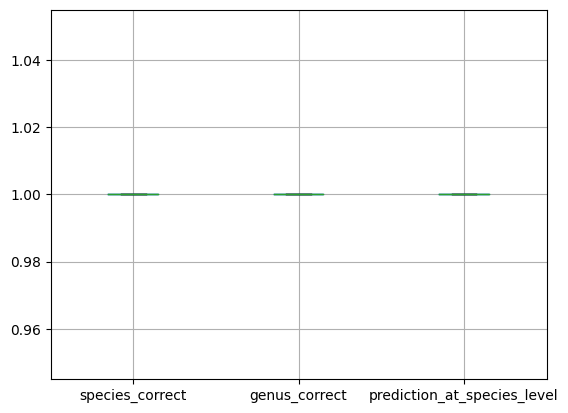

In [65]:
sum_res.boxplot(column=['species_correct', 'genus_correct', 'prediction_at_species_level'])